This is a document detailing how I constructed the simulated data for the Bio Data Scientist interview. The problem we're going to present is a standard CRISPR screening problem.  However, we're gonna generate the data with a few "gotchas" that can complicate the analysis.  This includes 
* guide variability
* GC content bias
* ??
* profit

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn

plt.style.use('ggplot')

In [2]:
n_genes = 2000
n_guides = 20
n_pos_hits = 100
n_neg_ctrl = 2000

In [3]:
gene_names = [str(i + 1) for i in range(n_genes)]
guide_df = pd.DataFrame({'gene': [g for g in gene_names for _ in range(n_guides)] + ['random']*n_neg_ctrl})
# add in negative control guides
print(guide_df.shape)
# check to make sure the numbers are correct
print(guide_df['gene'].value_counts().value_counts())

(42000, 1)
20      2000
2000       1
Name: gene, dtype: int64


In [4]:
guide_df['neg_ctrl'] = guide_df['gene'].map(lambda g: g == 'random')

In [5]:
np.random.seed(12345)

def generate_random_spacer(spacer_len = 20, 
                           DNA = ['A', 'C', 'G', 'T'],
                           probs = [0.3, 0.2, 0.2, 0.3]):
    s = np.random.choice(DNA, size = spacer_len, replace = True, p = probs)
    return ''.join(s)

guide_df['spacer'] = [generate_random_spacer() for _ in range(guide_df.shape[0])]
guide_df.shape

(42000, 3)

In [6]:
guide_df.head()

,gene,neg_ctrl,spacer
0,1,False,TCAAGGTGTGTTAAAGTTTT
1,1,False,GTCCCTTGTAATTACGGATT
2,1,False,TGTAAACCTAGATTGACCTT
3,1,False,CCGAAGTGTGTCCTGAATCT
4,1,False,TGATCCACGCTTTTATCTTA


In [7]:
# now generate labels
pos_genes = np.random.choice(list(range(1, n_genes + 1)), 
                             size = n_pos_hits,
                             replace = False)

guide_df['true_hit'] = guide_df['gene'].map(lambda g: 1 if g != 'random' and int(g) in pos_genes else 0)
# check that the numbers are correct, should be 20*100
guide_df['true_hit'].value_counts()

0    40000
1     2000
Name: true_hit, dtype: int64

In [8]:
# have 50% working guides
guide_df['working_guide'] = guide_df['true_hit']*np.random.binomial(n = 1, p = 0.5, size = guide_df.shape[0])
guide_df['working_guide'].value_counts()

0    40989
1     1011
Name: working_guide, dtype: int64

In [9]:
def gc_frac(s):
    gc_content = s.count('G') + s.count('C')
    return gc_content/float(len(s))

guide_df['gc_frac'] = guide_df['spacer'].map(lambda s: gc_frac(s))
guide_df.head()

,gene,neg_ctrl,spacer,true_hit,working_guide,gc_frac
0,1,False,TCAAGGTGTGTTAAAGTTTT,0,0,0.30
1,1,False,GTCCCTTGTAATTACGGATT,0,0,0.40
2,1,False,TGTAAACCTAGATTGACCTT,0,0,0.35
3,1,False,CCGAAGTGTGTCCTGAATCT,0,0,0.50
4,1,False,TGATCCACGCTTTTATCTTA,0,0,0.35


/Users/tim.daley/git/crispy_code/py39/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gc_frac'>

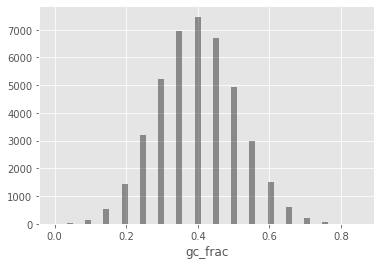

In [10]:
seaborn.distplot(guide_df['gc_frac'], kde = False, color = 'black')

<AxesSubplot:xlabel='true_effect', ylabel='Probability'>

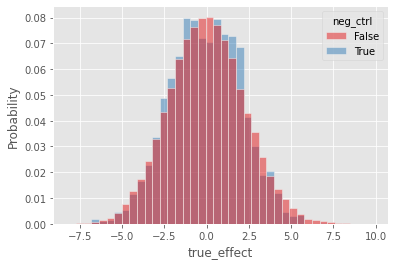

In [11]:
guide_df['true_effect'] = \
    guide_df['working_guide']*2.8 + \
    np.random.normal(loc = 0, scale = 1, size = guide_df.shape[0]) + \
    np.random.normal(loc = 15*guide_df['gc_frac'] - guide_df['gc_frac'].mean(),
                     scale = 1, size = guide_df.shape[0])
# shift to have mean zero
guide_df['true_effect'] = guide_df['true_effect'] - guide_df['true_effect'].mean()
seaborn.histplot(x = 'true_effect', bins = 40, hue = 'neg_ctrl', 
                 data = guide_df, stat = 'probability', common_norm = False,
                 palette="Set1")

/Users/tim.daley/git/crispy_code/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gc_frac', ylabel='true_effect'>

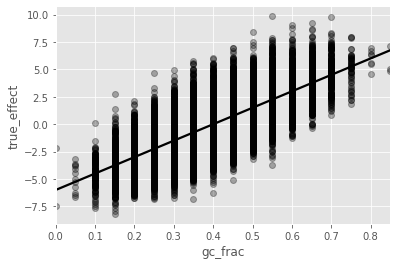

In [12]:
seaborn.regplot(guide_df['gc_frac'], guide_df['true_effect'], color = 'black', scatter_kws={'alpha':0.3})

Now we want to generate count data for the condition and control.  We'll simulate the counts as negative binomial random variables with mean equal $\mu_{ij} = \mu_{\text{i}} + 1(\text{condition})*$`true_effect` and variance equal to $\mu_{ij} + \alpha_{j} \mu_{ij}^2$.  We'll set $\alpha_{j} = 1$.  The numpy parametrization of the negative binomial requires $n$ and $p$, which gives the following pdf:
$$
p(x | n, p) = \frac{\Gamma(x + n)}{\Gamma(x + 1) \Gamma(n)} p^{n} (1 - p)^x.
$$
The $\alpha, \mu$ parametrization has pdf:
$$
p(x | \mu, \alpha) = \frac{\Gamma(x + \alpha^{-1})}{\Gamma(x + 1) \Gamma(\alpha^{-1})} \left( \frac{\mu}{\mu + \alpha^{-1}} \right)^x \left( \frac{1}{\alpha \mu + 1} \right)^{\alpha^{-1}}.
$$

Connecting the two gives the following connection between the parameters:
$$
\begin{aligned}
n &= \alpha^{-1}
\notag \\
p &= \frac{1}{\alpha \mu + 1}
\notag
\end{aligned}
$$

We'll have $\alpha$ sampled from a Gamma(1, 1) distribution, then set $p$.

In [13]:
mean_seq_depth = 100
alpha = np.random.gamma(shape = 0.1, scale = 10, size = guide_df.shape[0])
guide_df['control_1'] = np.random.negative_binomial(n = 1.0/alpha, p = 1.0/(alpha*mean_seq_depth + 1.0), size = guide_df.shape[0])
print(guide_df['control_1'].mean())

condition_mean = mean_seq_depth/np.exp(-guide_df['true_effect'])
print(np.mean(condition_mean))
condition_mean = (condition_mean/np.mean(condition_mean))*mean_seq_depth
print(np.mean(condition_mean))

guide_df['condition_1'] = np.random.negative_binomial(n = 1.0/alpha, p = 1.0/(alpha*condition_mean + 1.0), size = guide_df.shape[0])
print(guide_df['condition_1'].mean())
guide_df.head()

99.18928571428572
1425.4361193389582
100.00000000000003
99.69190476190477


,gene,neg_ctrl,spacer,true_hit,working_guide,gc_frac,true_effect,control_1,condition_1
0,1,False,TCAAGGTGTGTTAAAGTTTT,0,0,0.30,-1.147236,260,2
1,1,False,GTCCCTTGTAATTACGGATT,0,0,0.40,-0.510970,118,5
2,1,False,TGTAAACCTAGATTGACCTT,0,0,0.35,-0.948160,167,4
3,1,False,CCGAAGTGTGTCCTGAATCT,0,0,0.50,1.091860,88,26
4,1,False,TGATCCACGCTTTTATCTTA,0,0,0.35,-1.267974,96,1


In [14]:
guide_df['control_2'] = np.random.negative_binomial(n = 1.0/alpha, p = 1.0/(alpha*mean_seq_depth + 1.0), size = guide_df.shape[0])
guide_df['condition_2'] = np.random.negative_binomial(n = 1.0/alpha, p = 1.0/(alpha*condition_mean + 1.0), size = guide_df.shape[0])

In [15]:
guide_df.head()

,gene,neg_ctrl,spacer,true_hit,working_guide,gc_frac,true_effect,control_1,condition_1,control_2,condition_2
0,1,False,TCAAGGTGTGTTAAAGTTTT,0,0,0.30,-1.147236,260,2,14,8
1,1,False,GTCCCTTGTAATTACGGATT,0,0,0.40,-0.510970,118,5,97,3
2,1,False,TGTAAACCTAGATTGACCTT,0,0,0.35,-0.948160,167,4,83,3
3,1,False,CCGAAGTGTGTCCTGAATCT,0,0,0.50,1.091860,88,26,116,16
4,1,False,TGATCCACGCTTTTATCTTA,0,0,0.35,-1.267974,96,1,109,0


In [16]:
sum(guide_df['control_1'] + guide_df['control_2'] == 0)

1247

In [17]:
sum(guide_df['condition_1'] + guide_df['condition_2'] == 0)

6147

In [18]:
guide_df['naive_log_fc'] = \
    np.log(guide_df['condition_1'] + guide_df['condition_2'] + 1)  - \
    np.log(guide_df['control_1'] + guide_df['control_2'] + 1)
    
guide_df.head()

,gene,neg_ctrl,spacer,true_hit,working_guide,gc_frac,true_effect,control_1,condition_1,control_2,condition_2,naive_log_fc
0,1,False,TCAAGGTGTGTTAAAGTTTT,0,0,0.30,-1.147236,260,2,14,8,-3.218876
1,1,False,GTCCCTTGTAATTACGGATT,0,0,0.40,-0.510970,118,5,97,3,-3.178054
2,1,False,TGTAAACCTAGATTGACCTT,0,0,0.35,-0.948160,167,4,83,3,-3.446011
3,1,False,CCGAAGTGTGTCCTGAATCT,0,0,0.50,1.091860,88,26,116,16,-1.561810
4,1,False,TGATCCACGCTTTTATCTTA,0,0,0.35,-1.267974,96,1,109,0,-4.634729


<AxesSubplot:xlabel='true_effect', ylabel='naive_log_fc'>

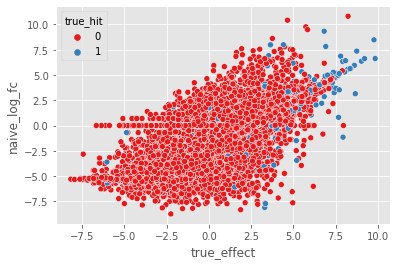

In [19]:
seaborn.scatterplot(data = guide_df, x = 'true_effect', y = 'naive_log_fc', 
                    hue = 'true_hit', palette = 'Set1')

<AxesSubplot:xlabel='true_effect', ylabel='naive_log_fc'>

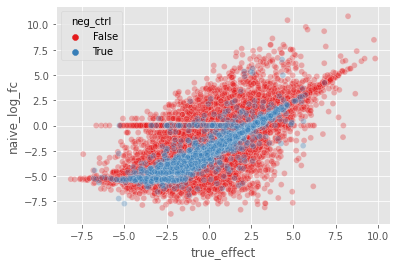

In [20]:
seaborn.scatterplot(data = guide_df, x = 'true_effect', y = 'naive_log_fc', 
                    alpha = 0.3, hue = 'neg_ctrl', palette = 'Set1')

<AxesSubplot:xlabel='naive_log_fc', ylabel='Probability'>

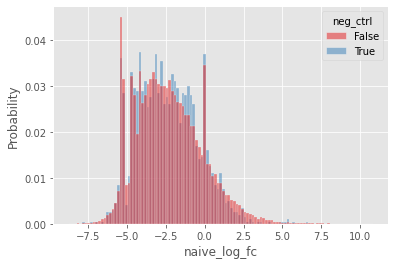

In [21]:
seaborn.histplot(data = guide_df, x = 'naive_log_fc', hue = 'neg_ctrl', palette = 'Set1', 
                 stat = 'probability', common_norm = False)

In [22]:
cols = ['gene', 'spacer', 'control_1', 'control_2', 'condition_1', 'condition_2']
guide_df[cols].to_csv("simulated_counts.txt", sep = '\t', header = True, index = False)

In [23]:
guide_df.to_csv("labeled_simulated_counts.txt", sep = '\t', header = True, index = False)